<a href="https://colab.research.google.com/github/sudarshan-360/Machine-Learning/blob/main/Saree_colour_combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mediapipe opencv-python

In [22]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [23]:
def hue_to_color(hue):
    if hue < 20:
        return 'Red'
    elif hue < 40:
        return 'Orange'
    elif hue < 75:
        return 'Yellow'
    elif hue < 150:
        return 'Green'
    elif hue < 210:
        return 'Cyan'
    elif hue < 270:
        return 'Blue'
    elif hue < 310:
        return 'Purple'
    else:
        return 'Pink'

In [24]:
def extract_skin_tone(image_path):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("❌ Error reading image.")
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    result = face_mesh.process(img_rgb)
    if not result.multi_face_landmarks:
        print("❌ No face detected.")
        return None

    landmarks = result.multi_face_landmarks[0].landmark
    indices = [10, 234, 454, 152]  # Cheek, forehead, etc.
    mask = np.zeros((h, w), dtype=np.uint8)

    for idx in indices:
        x, y = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
        cv2.circle(mask, (x, y), 20, 255, -1)

    hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    masked_pixels = hsv_img[np.where(mask == 255)]

    if len(masked_pixels) == 0:
        print("❌ No skin pixels found.")
        return None

    avg_hsv = np.mean(masked_pixels, axis=0)
    avg_h, avg_s, avg_v = [int(i) for i in avg_hsv]

    # Preview circles
    preview = img_bgr.copy()
    for idx in indices:
        x, y = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
        cv2.circle(preview, (x, y), 20, (0, 255, 0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
    plt.title(f"Extracted Skin Tone (HSV): {avg_h}, {avg_s}, {avg_v}")
    plt.axis('off')
    plt.show()

    return (avg_h, avg_s, avg_v)


In [25]:
print("📸 Upload your selfie image:")
uploaded_img = files.upload()
img_path = next(iter(uploaded_img))


📸 Upload your selfie image:


Saving WhatsApp Image 2025-08-05 at 19.39.21.jpeg to WhatsApp Image 2025-08-05 at 19.39.21 (3).jpeg


In [26]:
print("📊 Upload the saree dataset CSV:")
uploaded_csv = files.upload()
csv_path = next(iter(uploaded_csv))

📊 Upload the saree dataset CSV:


Saving saree_dataset_5000.csv to saree_dataset_5000 (3).csv


In [27]:
df = pd.read_csv(csv_path)

# Add readable color categories
df['body_color_cat'] = df['c1_body_H'].apply(hue_to_color)
df['border_color_cat'] = df['c1_border_H'].apply(hue_to_color)

# Encode categorical variables
le_body_color = LabelEncoder()
le_border_color = LabelEncoder()
le_border = LabelEncoder()
le_design = LabelEncoder()

df['body_color_cat_enc'] = le_body_color.fit_transform(df['body_color_cat'])
df['border_color_cat_enc'] = le_border_color.fit_transform(df['border_color_cat'])
df['border_type_enc'] = le_border.fit_transform(df['border_type'])
df['design_pattern_enc'] = le_design.fit_transform(df['design_pattern'])

In [33]:
X = df[['skin_H', 'skin_S', 'skin_V', 'border_type_enc', 'design_pattern_enc']]
y = df[['body_color_cat_enc', 'border_color_cat_enc']]

# 📚 STEP 6: Train the Model
y_pred = model.predict(X_test)

# Evaluate each output separately
y_pred_body = y_pred[:, 0]
y_pred_border = y_pred[:, 1]

y_test_body = y_test.iloc[:, 0]
y_test_border = y_test.iloc[:, 1]

acc_body = accuracy_score(y_test_body, y_pred_body)
acc_border = accuracy_score(y_test_border, y_pred_border)

print("✅ Model Accuracy:")
print(f"👗 Body Color Accuracy: {round(acc_body * 100, 2)}%")
print(f"🧵 Border Color Accuracy: {round(acc_border * 100, 2)}%")

✅ Model Accuracy:
👗 Body Color Accuracy: 17.3%
🧵 Border Color Accuracy: 15.6%


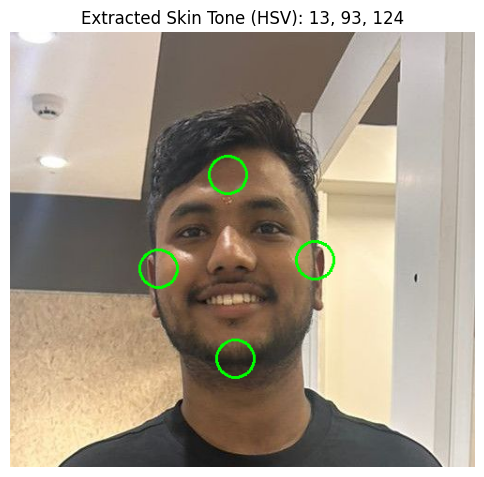


🎨 Recommended Saree Colors:
👗 Body Color: Red
🧵 Border Color: Cyan


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [34]:
skin_hsv = extract_skin_tone(img_path)
if skin_hsv:
    skin_H, skin_S, skin_V = skin_hsv

    # 🎛️ USER INPUT: border type and design pattern — must match your dataset
    user_border_type = "Small"     # Example: Small, Big, etc.
    user_design_pattern = "Floral" # Example: Floral, Plain, etc.

    # Check if user inputs exist in label encoders
    if user_border_type not in le_border.classes_ or user_design_pattern not in le_design.classes_:
        print("❌ Provided border type or design pattern not found in dataset.")
    else:
        encoded_border_type = le_border.transform([user_border_type])[0]
        encoded_design = le_design.transform([user_design_pattern])[0]

        input_data = [[skin_H, skin_S, skin_V, encoded_border_type, encoded_design]]
        prediction = model.predict(input_data)
        body_color_cat_enc, border_color_cat_enc = prediction[0]

        # Decode prediction
        body_color = le_body_color.inverse_transform([body_color_cat_enc])[0]
        border_color = le_border_color.inverse_transform([border_color_cat_enc])[0]

        print("\n🎨 Recommended Saree Colors:")
        print(f"👗 Body Color: {body_color}")
        print(f"🧵 Border Color: {border_color}")
